# 18기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.
데이터셋 출처 :  https://www.kaggle.com/datasets/shenba/time-series-datasets

### Box-Jenkins 방법론
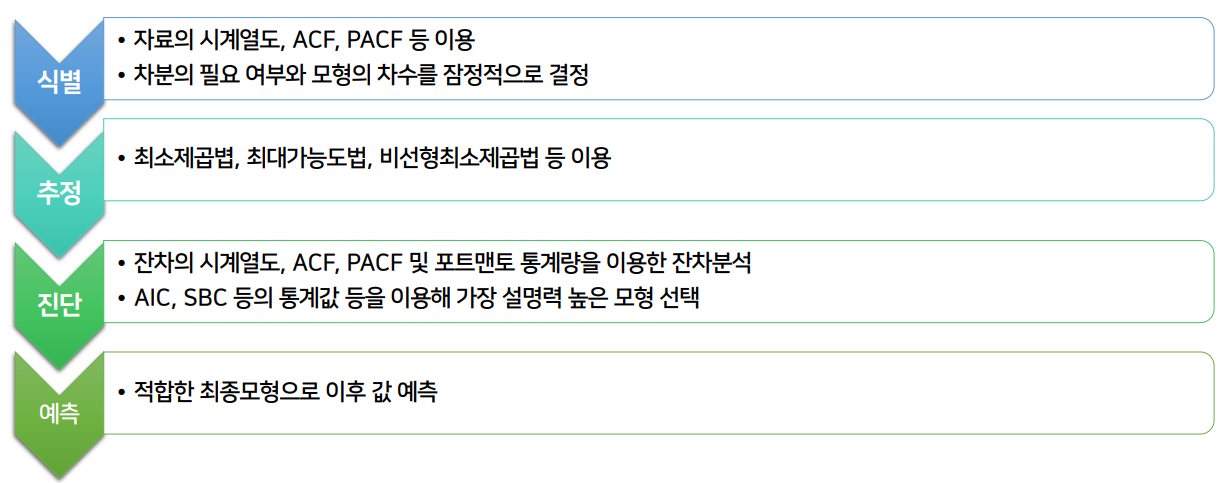
대략적 흐름 예시를 확인하고 싶다면 첨부한 '시계열자료_참고자료.pdf'를 읽어주세요.

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 데이터 불러오기

In [2]:
df = pd.read_csv('./Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [4]:
# 날짜 데이터타입 변경
df.DATE = pd.to_datetime(df.DATE)

# 날짜 index 설정
df.set_index('DATE', inplace = True)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
df.index.freq = 'MS'

## 원본 데이터 시각화

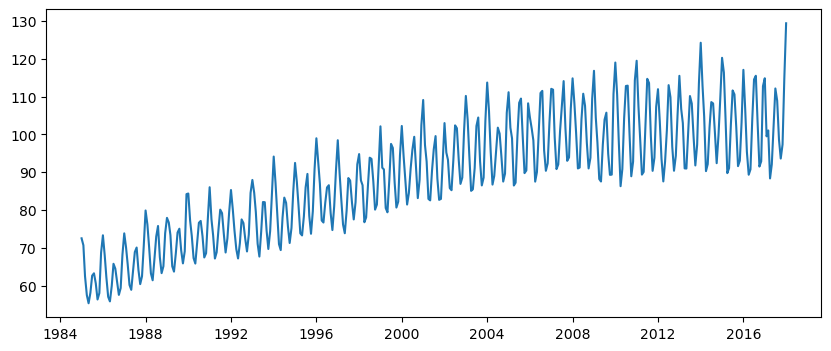

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["IPG2211A2N"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show()

* 상승하는 추세를 보임

## 시계열 분해 (추세/계절성/불규칙)

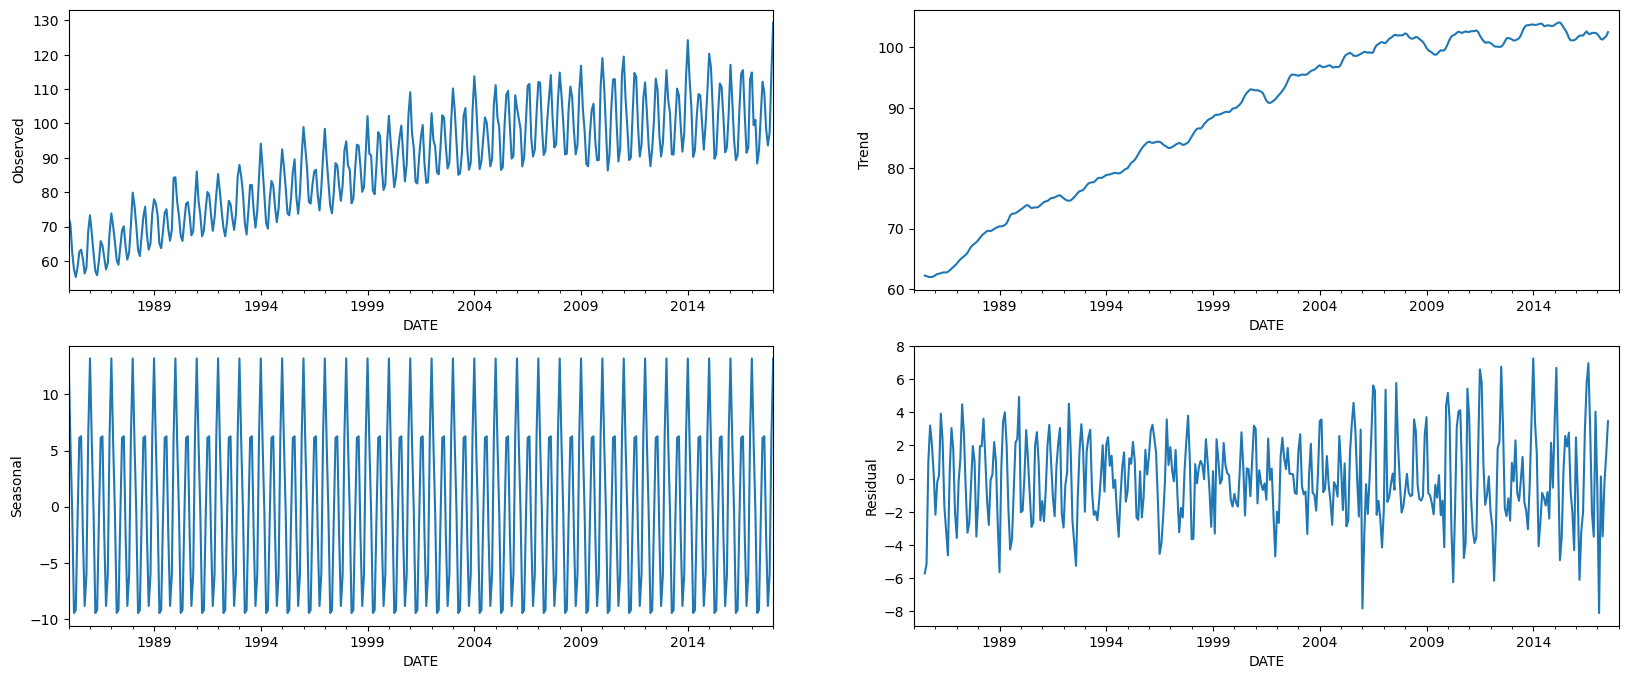

In [7]:
# 가법 적용 분해법
fig, axes = plt.subplots(2,2, figsize=(20,8))
a = seasonal_decompose(df["IPG2211A2N"], model = "add")
a.observed.plot(legend=False, ax=axes[0][0])
axes[0][0].set_ylabel('Observed')
a.trend.plot(legend=False, ax=axes[0][1])
axes[0][1].set_ylabel('Trend')
a.seasonal.plot(legend=False, ax=axes[1][0])
axes[1][0].set_ylabel('Seasonal')
a.resid.plot(legend=False, ax=axes[1][1])
axes[1][1].set_ylabel('Residual')
plt.show()

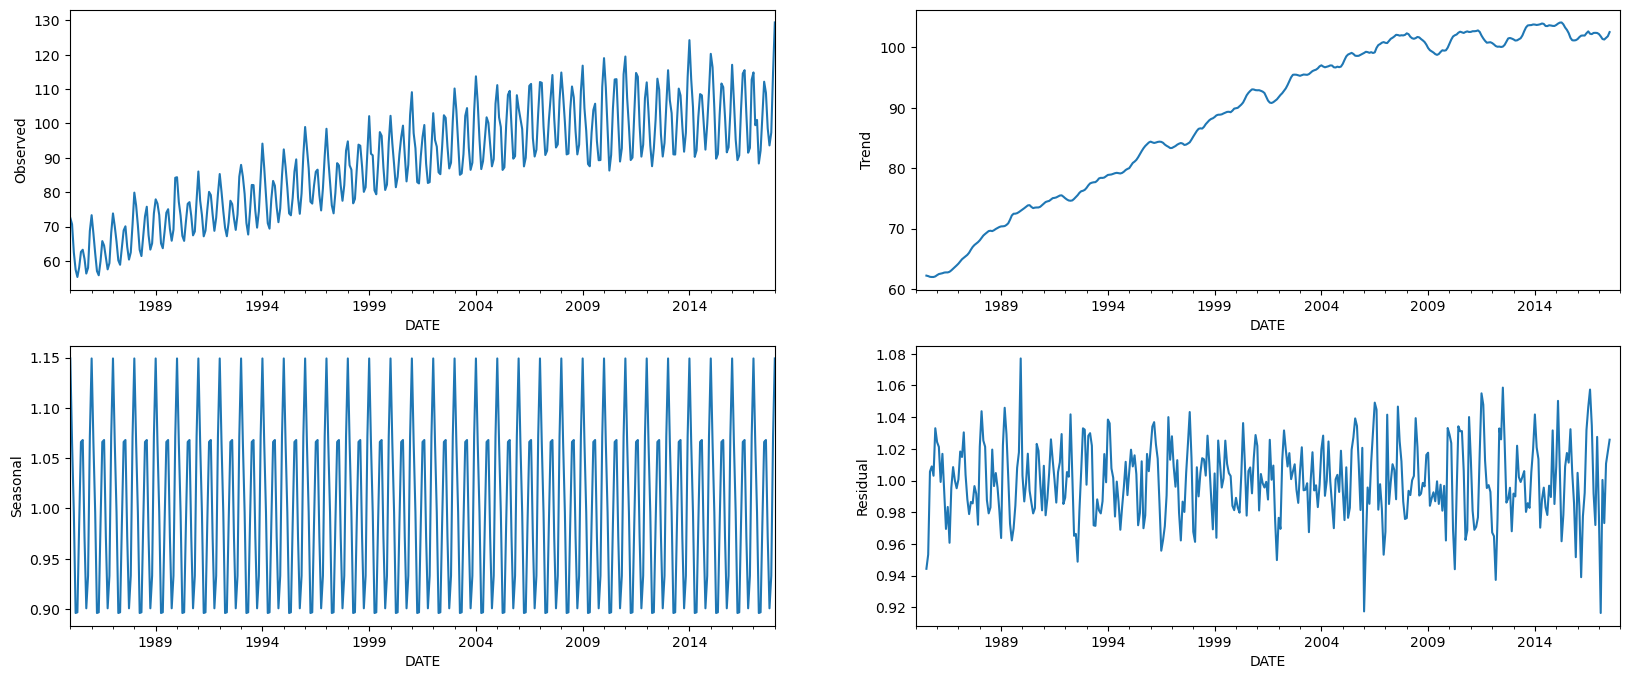

In [8]:
# 승법 적용 분해법
fig, axes = plt.subplots(2,2, figsize=(20,8))
b = seasonal_decompose(df["IPG2211A2N"], model = "multiplicative")
b.observed.plot(legend=False, ax=axes[0][0])
axes[0][0].set_ylabel('Observed')
b.trend.plot(legend=False, ax=axes[0][1])
axes[0][1].set_ylabel('Trend')
b.seasonal.plot(legend=False, ax=axes[1][0])
axes[1][0].set_ylabel('Seasonal')
b.resid.plot(legend=False, ax=axes[1][1])
axes[1][1].set_ylabel('Residual')
plt.show()

* 추세성(trend), 계절성(seasonal) 존재

## 시계열 정상성(Stationarity) 여부 확인

* 통계적 가설 검정을 이용해 정상성(stationarity) 여부를 확인하는 방법
    * Augmented Dickey-Fuller (ADF) test
        * H0: 정상 시계열이 아니다
        * H1: 정상 시계열이다.
    * Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
        * H0: 정상 시계열이다.
        * H1: 정상 시계열이 아니다.



In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    adftest = adfuller(timeseries)
    
    print(f'ADF Statistic: {adftest[0]}')
    print(f'p-value: {adftest[1]}')
    print(f'Result: The series is {"" if adftest[1] < 0.05 else "not"} stationary')

adf_test(df["IPG2211A2N"])

ADF Statistic: -2.256990350047244
p-value: 0.18621469116586792
Result: The series is not stationary


In [10]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):    
    kpsstest = kpss(timeseries)
    
    print(f'KPSS Statistic: {kpsstest[0]}')
    print(f'p-value: {kpsstest[1]}')
    print(f'Result: The series is {"not" if kpsstest[1] < 0.05 else ""} stationary')
    
kpss_test(df["IPG2211A2N"])

KPSS Statistic: 3.5315970094994857
p-value: 0.01
Result: The series is not stationary


* 비정상 시계열

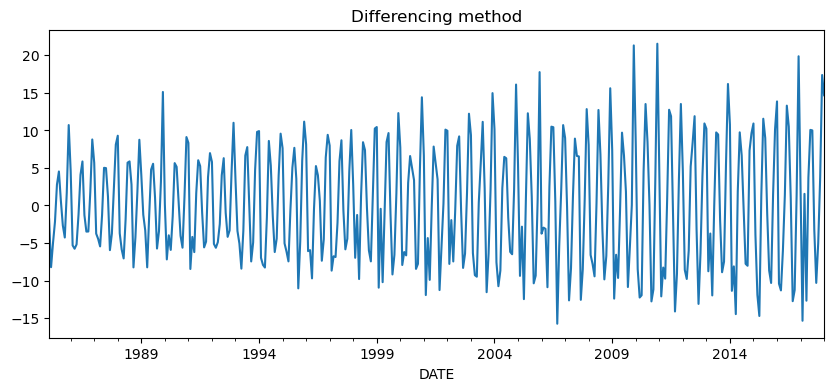

In [11]:
# 비정상 시계열 => 정상 시계열로 변환
# 1차 차분

plt.figure(figsize=(10,4))
df_diff = df["IPG2211A2N"].diff(1) 
df_diff.dropna(inplace=True)
df_diff.plot()
plt.title("Differencing method")
plt.show()

In [12]:
adf_test(df_diff)

ADF Statistic: -7.104890882267284
p-value: 4.077786565540049e-10
Result: The series is  stationary


In [13]:
kpss_test(df_diff)

KPSS Statistic: 0.14518934657460805
p-value: 0.1
Result: The series is  stationary


* 정상성 만족

## ACF, PACF 확인
* 자기상관함수(Autocorrelation Fucntion, ACF)
* 편자기상관함수(Partial Autocorrelation Fucntion, PACF)

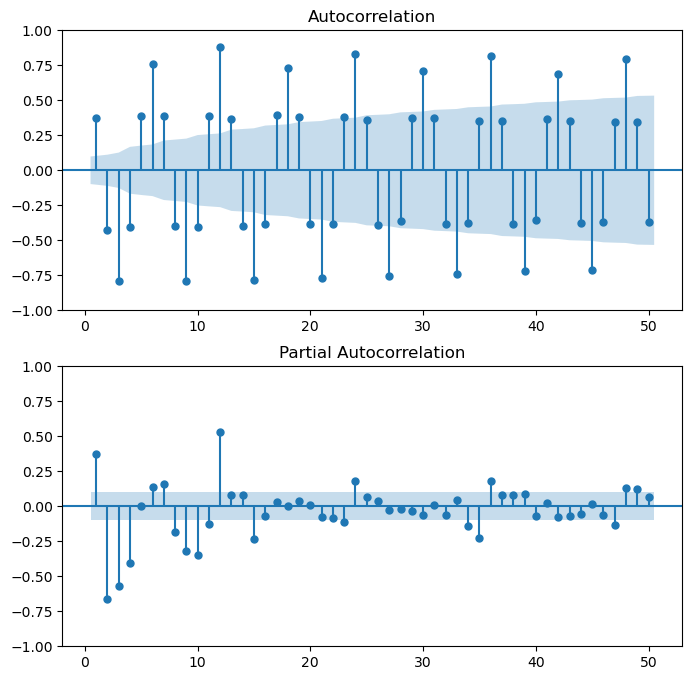

In [14]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df_diff,lags=50, zero=False, ax=ax1)
plot_pacf(df_diff,lags=50, zero=False, ax=ax2)
plt.show()

## ARIMA 

In [15]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima
import pmdarima as pm

pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=5, max_q=5, seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, test='adf', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1787.226, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2010.162, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1940.101, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1835.298, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1785.652, Time=0.45 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1786.885, Time=3.57 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1872.182, Time=0.34 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1785.329, Time=3.43 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1770.670, Time=7.86 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1773.643, Time=3.74 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1814.635, Time=3.62 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1835.292, Time=2.72 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=1772.091, Time=4.60 sec
 ARIMA(1,1,2)(2,1,2)[12]

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 2, 12),
      suppress_warnings=True)

In [16]:
# 데이터셋 분리 (train, test)
train = df[:len(df)-12]
test = df[len(df)-12:]

In [17]:
arima_model = SARIMAX(train,order=(1,1,1),  seasonal_order=(2, 1, 2, 12))
result = arima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28666D+00    |proj g|=  1.15187D-01


 This problem is unconstrained.



At iterate    5    f=  2.21358D+00    |proj g|=  3.77457D-02

At iterate   10    f=  2.18430D+00    |proj g|=  8.66024D-03

At iterate   15    f=  2.18023D+00    |proj g|=  1.11952D-02

At iterate   20    f=  2.17778D+00    |proj g|=  8.32823D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     30      1     0     0   5.883D-06   2.178D+00
  F =   2.1777818112838134     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              IPG2211A2N   No. Observations:                  385
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -838.446
Date:                                 Wed, 24 Aug 2022   AIC                           1690.892
Time:                                         00:28:30   BIC                           1718.324
Sample:                                     01-01-1985   HQIC                          1701.786
                                          - 01-01-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4976      0.050      9.901      0.000       0.399       0.596
ma.L1         -0.9488      0.019    -49.892      0.000      -0.986      -0.912
ar.S.L12       0.6177      0.176      3.512      0.000       0.273       0.963
ar.S.L24      -0.2780      0.062     -4.454      0.000      -0.400      -0.156
ma.S.L12      -1.3278      0.174     -7.633      0.000      -1.669      -0.987
ma.S.L24       0.5258      0.142      3.713      0.000       0.248       0.803
sigma2         5.1069      0.339     15.083      0.000       4.443       5.771
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                13.54
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.54   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
forecast = result.get_forecast(steps=len(test))
predicts = forecast.predicted_mean
predicts

2017-02-01    106.376504
2017-03-01     98.280188
2017-04-01     89.350719
2017-05-01     91.476155
2017-06-01    102.905057
2017-07-01    112.853181
2017-08-01    112.019329
2017-09-01    100.551995
2017-10-01     91.599309
2017-11-01     95.484786
2017-12-01    111.195669
2018-01-01    118.409459
Freq: MS, Name: predicted_mean, dtype: float64

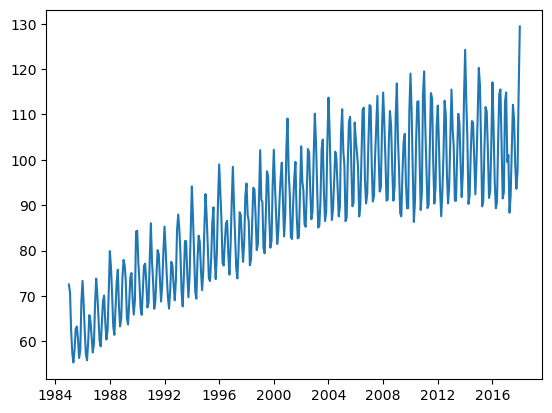

In [20]:
plt.plot(df)

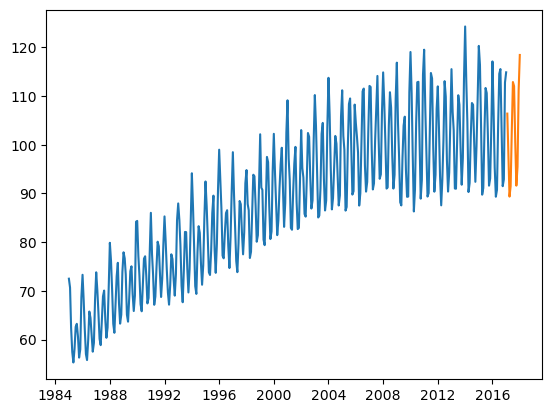

In [21]:
plt.plot(train)
plt.plot(predicts)

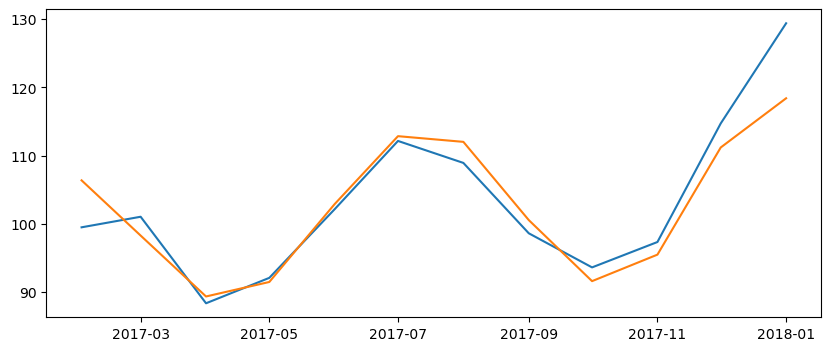

In [22]:
plt.figure(figsize=(10,4))
plt.plot(test.index, test['IPG2211A2N'])
plt.plot(test.index, predicts)

In [23]:
from sklearn.metrics import r2_score, mean_squared_error

print(f'R2_score: {r2_score(test, predicts)}')
print(f'RMSE: {mean_squared_error(test, predicts) ** 0.5}')

R2_score: 0.8534292458119773
RMSE: 4.198712476603856
